# Final Project for Data Analytics

## Alyssa June Pacleb, Ravi Goparaju, Adeena Amersi, Ryan Chiapoco

We are trying to predict the political party subjects donate to given their occupation, donation amount, election phase, and year.

In [4]:
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.svm import SVC 
from sklearn.pipeline import Pipeline


%matplotlib inline

# Data Preparation and Feature Engineering

In [5]:
url = 'https://media.githubusercontent.com/media/fivethirtyeight/data/master/science-giving/science_federal_giving.csv'
df = pd.read_csv(url, error_bad_lines=False)

In [6]:
print(df.shape)
df.head()

(881793, 31)


,cmte_nm,cmte_id,cmte_tp,cmte_pty,cand_name,cand_pty_affiliation,cand_office_st,cand_office,cand_office_district,cand_status,...,transaction_dt,cycle,transaction_amt,2016_dollars,other_id,tran_id,file_num,memo_cd,memo_text,sub_id
0,AMERICAN WAY - DURANT 2012; THE,C00501452,S,REP,"DURANT, CLARK",REP,MI,S,0.0,C,...,3302012.0,2012.0,2500.0,2612.50,NaN,SA0108160812336,845273.0,NaN,NaN,1.010000e+18
1,A LOT OF PEOPLE FOR DAVE OBEY,C00017830,H,DEM,"OBEY, DAVID R",DEM,WI,H,7.0,C,...,4182007.0,2008.0,250.0,292.50,NaN,C34559,294636.0,NaN,NaN,4.070000e+18
2,A WHOLE LOT OF PEOPLE FOR GRIJALVA CONGRESSION...,C00374058,H,DEM,"GRIJALVA, RAUL M",DEM,AZ,H,3.0,C,...,6092016.0,2016.0,50.0,50.00,C00401224,VSH8VCDY4S4,1096417.0,NaN,* EARMARKED CONTRIBUTION: SEE BELOW,4.080000e+18
3,A WHOLE LOT OF PEOPLE FOR GRIJALVA CONGRESSION...,C00374058,H,DEM,"GRIJALVA, RAUL M",DEM,AZ,H,3.0,C,...,8192012.0,2012.0,2500.0,2612.50,NaN,C6548162,863428.0,NaN,NaN,4.030000e+18
4,A WHOLE LOT OF PEOPLE FOR GRIJALVA CONGRESSION...,C00374058,H,DEM,"GRIJALVA, RAUL M",DEM,AZ,H,7.0,C,...,10292010.0,2010.0,250.0,273.25,NaN,C5156783,863417.0,NaN,NaN,4.030000e+18


In [7]:
print(df.isna().sum()) # Clearly there is a bit of an issue here

cmte_nm                 411590
cmte_id                 411590
cmte_tp                 411590
cmte_pty                411796
cand_name               497992
cand_pty_affiliation    497997
cand_office_st          497992
cand_office             497992
cand_office_district    498030
cand_status             498076
rpt_tp                  411590
transaction_pgi         451317
transaction_tp          411590
entity_tp               411636
cleaned_name            411616
city                    411668
state                   412250
zip_code                412151
employer                413929
cleanedoccupation       411590
classification          411590
transaction_dt          411597
cycle                   411597
transaction_amt         411590
2016_dollars            411619
other_id                783423
tran_id                 411590
file_num                411590
memo_cd                 878451
memo_text               697623
sub_id                  411590
dtype: int64


In [8]:
# We don't care about these features because they don't give us additional information and they are redundant.
new = df.drop(columns=['cand_pty_affiliation', 'state',"cand_office",'cand_name', 'cleanedoccupation','cand_office_st', 'cleaned_name','employer','cmte_nm', 'cmte_id' , 'cmte_tp', 'cand_office_district', 'transaction_amt', 'cand_status', 'rpt_tp', 'transaction_tp', 'tran_id', 'file_num', 'memo_cd', 'memo_text', 'sub_id', 'other_id', 'zip_code', "cand_name", 'entity_tp', 'city','transaction_dt'])

# We only want to look at the general presidential election donations
new = new[(new['cmte_pty'] == 'DEM') | (new['cmte_pty'] == 'REP')]

# Keep only General and Primary election values in the transaction_pgi column
new = new[(new['transaction_pgi'] == 'G') | (new['transaction_pgi'] == 'P')]

new['cmte_pty'].replace(to_replace = 'dem', value = 'DEM', inplace = True)
new['cmte_pty'].replace(to_replace = 'Dem', value = 'DEM', inplace = True)

# Standardize the label of the Republican party
new['cmte_pty'].replace(to_replace = 'rep', value = 'REP', inplace = True)
new['cmte_pty'].replace(to_replace = 'Rep', value = 'REP', inplace = True)

new = new.dropna()
new['cycle'] = new['cycle'].astype(int)
print(new.isna().sum()) 
print(new.shape)
new.head()

cmte_pty           0
transaction_pgi    0
classification     0
cycle              0
2016_dollars       0
dtype: int64
(422393, 5)


,cmte_pty,transaction_pgi,classification,cycle,2016_dollars
0,REP,P,Engineer,2012,2612.50
1,DEM,P,Engineer,2008,292.50
2,DEM,P,Engineer,2016,50.00
3,DEM,P,Engineer,2012,2612.50
4,DEM,G,Scientist,2010,273.25


In [9]:
print(new['cmte_pty'].value_counts())
print(new.shape)

DEM    321200
REP    101193
Name: cmte_pty, dtype: int64
(422393, 5)


# Data Exploration

We found that the two major parties were the Democratic and Republican parties. We used seaborn package to view our categorical variables with heat maps. We found that approximately 75% of donations were to the Democratic party while 25% were to the Republican party. Primary elections resulted in the most donations while engineers was the group that donated over other occupation groups.

The median donation value to the Republican party was larger than that of the Democratic party, $50 and $253.50 respectively. The majority of the donations were below $500.

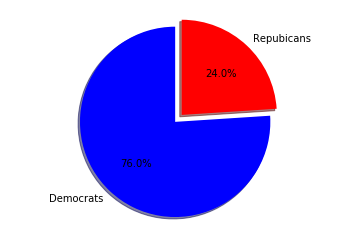

[Text(0, 0, 'Democrat'), Text(0, 0, 'Republican')]

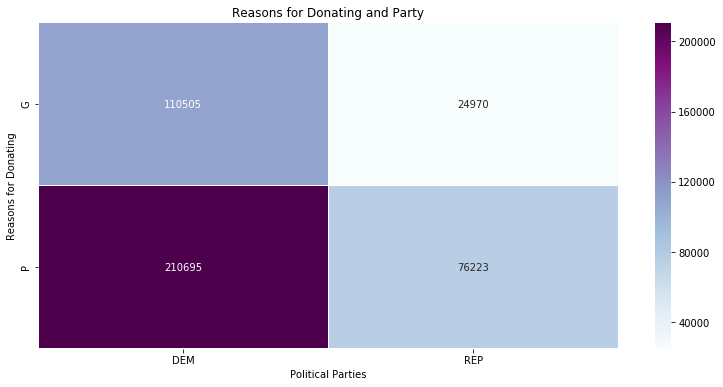

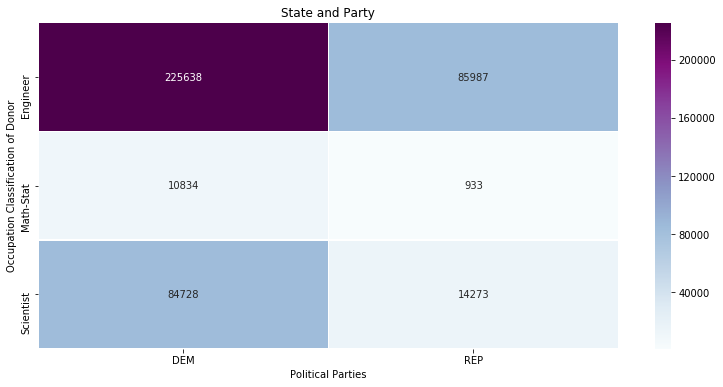

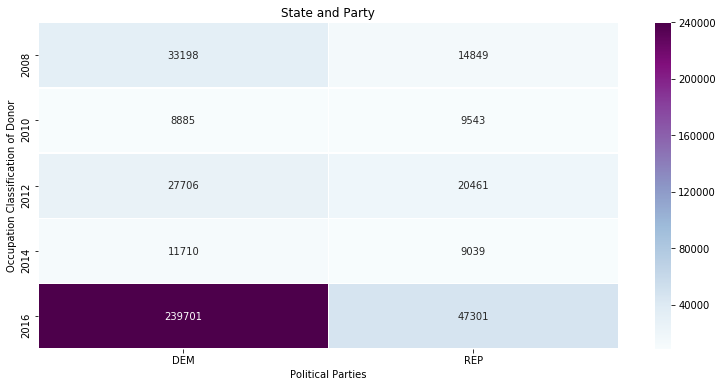

<Figure size 432x288 with 0 Axes>

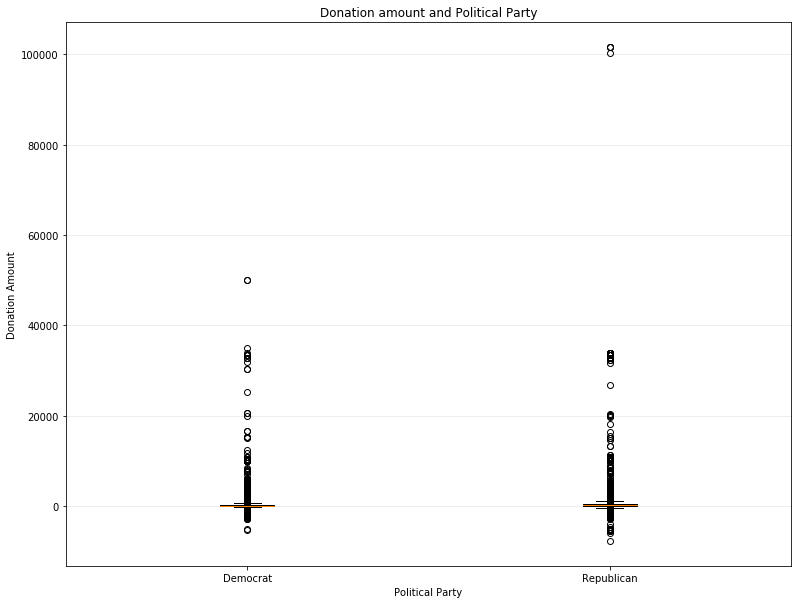

In [10]:
import seaborn as sns

dem_percentage = 320692/421803*100 #ew oh well
rep_percentage = 101111/421803*100

dem = new[new['cmte_pty'] == 'DEM']
rep = new[new['cmte_pty'] == 'REP']
lib = new[new['cmte_pty'] == 'LIB']

ticklabels = ['Democrat', 'Republican']

colors = ["blue", "red"]

# 1 cmte_pty
labels = 'Democrats', 'Repubicans'
sizes = [dem_percentage, rep_percentage]
explode = (0, 0.1)  # only "explode" the 2nd slice
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, colors = colors)
ax1.axis('equal') 
plt.show()

# 2 transaction_pgi
state_graph = new.groupby(['transaction_pgi','cmte_pty']).size().reset_index(name='counts')
state_piv = state_graph.pivot("transaction_pgi", "cmte_pty", "counts")
state_piv = state_piv.replace(np.nan, 0) 
fig2, ax2 = plt.subplots(figsize=(13, 6))
sns.heatmap(state_piv, annot=True, linewidths=.5, ax=ax2, cmap='BuPu',fmt='g')
ax2.axes.set_title("Reasons for Donating and Party");
ax2.axes.set_xlabel('Political Parties')
ax2.axes.set_ylabel('Reasons for Donating')

# 3 classification
occupation_graph = new.groupby(['classification','cmte_pty']).size().reset_index(name='counts')
occupation_piv = occupation_graph.pivot("classification", "cmte_pty", "counts")
occupation_piv = occupation_piv.replace(np.nan, 0) 
fig3, ax3 = plt.subplots(figsize=(13, 6))
sns.heatmap(occupation_piv, annot=True, linewidths=.5, ax=ax3, cmap='BuPu',fmt='g')
ax3.axes.set_title("State and Party");
ax3.axes.set_xlabel('Political Parties')
ax3.axes.set_ylabel('Occupation Classification of Donor')

# 4 cycle
cycle_graph = new.groupby(['cycle','cmte_pty']).size().reset_index(name='counts')
cycle_piv = cycle_graph.pivot("cycle", "cmte_pty", "counts")
cycle_piv = cycle_piv.replace(np.nan, 0) 
fig5, ax5 = plt.subplots(figsize=(13, 6))
sns.heatmap(cycle_piv, annot=True, linewidths=.5, ax=ax5, cmap='BuPu',fmt='g')
ax5.axes.set_title("State and Party");
ax5.axes.set_xlabel('Political Parties')
ax5.axes.set_ylabel('Occupation Classification of Donor')

# 5 2016_dollars
plt.figure()
fig6, ax6 = plt.subplots(figsize=(13, 10))
ax6.set_title('Donation amount and Political Party')
ax6.set_xlabel('Political Party')
ax6.set_ylabel('Donation Amount')
ax6.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)
ax6.boxplot([dem['2016_dollars'], rep['2016_dollars']])
ax6.set_xticklabels(ticklabels)

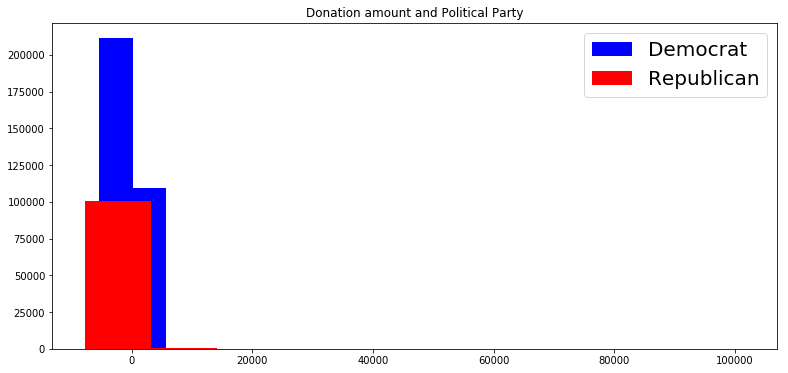

In [11]:
fig7, ax7 = plt.subplots(figsize=(13, 6))
ax7.set_title('Donation amount and Political Party')
ax7.hist(new['2016_dollars'][new['cmte_pty'] == "DEM"], color = "blue", label = "Democrat")
ax7.hist(new['2016_dollars'][new['cmte_pty'] == "REP"], color = "red", label = "Republican")
ax7.legend(prop={'size': 20});

# Downsampling

Because approximately 75% of the donations were made to the democratic party, we downsampled our dataset to be representative of the entire dataset.

In [12]:
dem_percentage = 320692/421803*100 
rep_percentage = 101111/421803*100

print(dem_percentage) 
print(rep_percentage)

76.02885707308862
23.97114292691138


In [13]:
only_dems = new[new['cmte_pty'] == 'DEM']
only_reps = new[new['cmte_pty'] == 'REP']

In [14]:
# We are cutting our dataset down to 5% of what it was before
dem_part = only_dems.sample(frac = 0.05) 
print(dem_part.shape)
rep_part = only_reps.sample(frac = 0.05) 
print(rep_part.shape)

(16060, 5)
(5060, 5)


In [15]:
# Combine the 3 parties to one dataframe 
frames = [dem_part, rep_part] 
stratified_sample = pd.concat(frames)

In [16]:
stratified_sample.shape

(21120, 5)

In [17]:
for col in stratified_sample: 
    print(col)

cmte_pty
transaction_pgi
classification
cycle
2016_dollars


# Analysis

In [19]:
# unique values of categorical variable implying the need of one-hot encoding
print(stratified_sample.head())
print()
print("Classification :",stratified_sample.classification.unique())
print("Election Phase :",stratified_sample.transaction_pgi.unique())

       cmte_pty transaction_pgi classification  cycle  2016_dollars
697705      DEM               P      Scientist   2014        253.25
481241      DEM               G      Scientist   2016         50.00
474892      DEM               P       Engineer   2016        101.40
584758      DEM               P       Engineer   2016        215.00
863615      DEM               P      Math-Stat   2014        506.50

Classification : ['Scientist' 'Engineer' 'Math-Stat']
Election Phase : ['P' 'G']


In [23]:
# One hot encoding needed as some of the features are categorical

# convert features to numeric values
sample = stratified_sample.copy()
sample['cycle'] = pd.to_numeric(sample['cycle'])
sample['2016_dollars'] = pd.to_numeric(sample['2016_dollars'])

# convert dataframe to array
cycle = sample["cycle"].to_numpy()
dollars = sample["2016_dollars"].to_numpy()
cmte_pty = sample["cmte_pty"].to_numpy()
sample = sample.drop(["2016_dollars","cycle", "cmte_pty"], axis=1)

# encode labels with value between 0 and n_classes-1.
le = preprocessing.LabelEncoder()

# fit and transform
X = sample.apply(le.fit_transform)
X.head()
enc = preprocessing.OneHotEncoder()
enc.fit(X)
onehotlabels = enc.transform(X).toarray()

# merge numeric variable and one-hot encoded variables and rename them
data_sample = pd.DataFrame(onehotlabels)
data_sample["cycle"] = cycle
data_sample["2016_dollars"] = dollars
data_sample["cmte_pty"] = cmte_pty
data_sample.rename(columns = {0:'general_election', 1:'primary_election', 2:'engineer', 3:'scientist', 4:'math-stat'}, inplace = True)

print(data_sample.shape)
data_sample.head(5)

(21120, 8)


,general_election,primary_election,engineer,scientist,math-stat,cycle,2016_dollars,cmte_pty
0,0.0,1.0,0.0,0.0,1.0,2014,253.25,DEM
1,1.0,0.0,0.0,0.0,1.0,2016,50.00,DEM
2,0.0,1.0,1.0,0.0,0.0,2016,101.40,DEM
3,0.0,1.0,1.0,0.0,0.0,2016,215.00,DEM
4,0.0,1.0,0.0,1.0,0.0,2014,506.50,DEM


In [24]:
# separating class labels from features
data_Y = data_sample["cmte_pty"]
data_X = data_sample.drop(["cmte_pty"],axis=1)
print("Features:", data_X.shape) 
print("Class Label:", data_Y.shape) 

Features: (21120, 7)
Class Label: (21120,)


## Support Vector Machine

In [102]:
# convert int to float to make scaling easier
data_X['cycle'] = data_X['cycle'].astype(float)

# scaling is required for SVM
scaler = StandardScaler()
svm = SVC()
pipe = Pipeline(steps=[('scaler', scaler), ('svm', svm)])

In [103]:
from sklearn.model_selection import GridSearchCV
# for the 'svm' part of the pipeline, tune the 'kernel' hyperparameter
param_grid = {'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid']}

# finding best kernel
grid_search_2 = GridSearchCV(pipe, param_grid, cv=5)
grid_search_2.fit(data_X, data_Y)
print(grid_search_2.best_params_)

{'svm__kernel': 'rbf'}


In [63]:
# nested cross validation
y_pred_2 = cross_val_predict(svm_2, data_X_scaled, data_Y, cv=5)
nested_score = cross_val_score(grid_search_2, data_X, data_Y, cv=5)

# accuracy
print("Accuracy:", nested_score.mean()*100)
print()

# confusion matrix
conf_matrix = confusion_matrix(data_Y, y_pred_2)
print("Confusion Matrix:")
print(conf_matrix)
print()

# classification report
print("Classification Report")
print(classification_report(data_Y, y_pred_2))

Accuracy: 76.49147727272727

Confusion Matrix:
[[16060     0]
 [ 5060     0]]

Classification Report


C:\Users\adeena\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\adeena\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

         DEM       0.76      1.00      0.86     16060
         REP       0.00      0.00      0.00      5060

   micro avg       0.76      0.76      0.76     21120
   macro avg       0.38      0.50      0.43     21120
weighted avg       0.58      0.76      0.66     21120



C:\Users\adeena\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The accuracy for this model is 76.49. I have also reported confusion matrix and classification report. As the dataset deals with imbalance issue, F-score will be useful in measuring accuracy. The F-score for Democrats is 0.86 and F-score for Republicans is 0. It means that none of the prediction was correct for Republican and all of the predictions were correct for Democrats. So the prediction was that all are Democrats.

## K nearest neighbor

In [57]:
# scaling features for KNN
data_X_scaled = MinMaxScaler().fit_transform(data_X)

In [59]:
# using the model KNN
knn_2 = KNeighborsClassifier()
knn_2.fit(data_X_scaled, data_Y)

# find the best parameter k
params = {'n_neighbors': np.arange(1, 10)}
grid_search = GridSearchCV(knn_2, params, cv=5, scoring = "accuracy")
grid_search.fit(data_X_scaled, data_Y)
print(grid_search.best_params_)
k = grid_search.best_params_['n_neighbors']

{'n_neighbors': 7}


In [62]:
# classify using knn
knn = KNeighborsClassifier(n_neighbors= k)

# nested cross validation
y_pred = cross_val_predict(knn, data_X_scaled, data_Y, cv=5)
nested_score = cross_val_score(grid_search, data_X, data_Y, cv=5)

# accuracy
print("Accuracy:", nested_score.mean()*100)
print()

# confusion matrix
conf_matrix = confusion_matrix(data_Y, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print()

# classification report
print("Classification Report")
print(classification_report(data_Y, y_pred))

Accuracy: 76.25946969696969

Confusion Matrix:
[[15818   242]
 [ 4710   350]]

Classification Report
              precision    recall  f1-score   support

         DEM       0.77      0.98      0.86     16060
         REP       0.59      0.07      0.12      5060

   micro avg       0.77      0.77      0.77     21120
   macro avg       0.68      0.53      0.49     21120
weighted avg       0.73      0.77      0.69     21120



The accuracy for this model was 76.25. I have also reported confusion matrix and classification report. As the dataset deals with imbalance issue, F-score will be useful in measuring accuracy. It indicates that F-score for Democratic is pretty good with 0.86 while F-score for Republicans is low with 0.12.